In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df_hits = pd.read_csv('~/project_sbr/data/data_analytics/processing_hits.csv')
df_sessions = pd.read_csv('~/project_sbr/data/data_analytics/processing_sessions.csv')
df = pd.merge(df_hits, df_sessions, on='session_id', how='inner')

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1175631 entries, 0 to 1175630
Data columns (total 24 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   session_id                1175631 non-null  object 
 1   hit_date                  1175631 non-null  object 
 2   hit_time                  1175631 non-null  float64
 3   hit_number                1175631 non-null  int64  
 4   hit_page_path             1175631 non-null  object 
 5   event_category            1175631 non-null  object 
 6   event_action              1175631 non-null  object 
 7   target                    1175631 non-null  int64  
 8   client_id                 1175631 non-null  float64
 9   visit_date                1175631 non-null  object 
 10  visit_time                1175631 non-null  object 
 11  visit_number              1175631 non-null  int64  
 12  utm_source                1175631 non-null  object 
 13  utm_medium                1

In [3]:
corr_matrix = df[['hit_time', 'hit_number', 'target', 'client_id', 'organic_traff',  'visit_number']].corr()
corr_matrix

,hit_time,hit_number,target,client_id,organic_traff,visit_number
hit_time,1.000000,0.369052,0.078420,-0.000183,0.082908,0.014597
hit_number,0.369052,1.000000,0.256287,0.000345,0.157449,-0.003845
target,0.078420,0.256287,1.000000,-0.000683,0.045889,0.012666
client_id,-0.000183,0.000345,-0.000683,1.000000,-0.000608,0.012108
organic_traff,0.082908,0.157449,0.045889,-0.000608,1.000000,0.116733
visit_number,0.014597,-0.003845,0.012666,0.012108,0.116733,1.000000


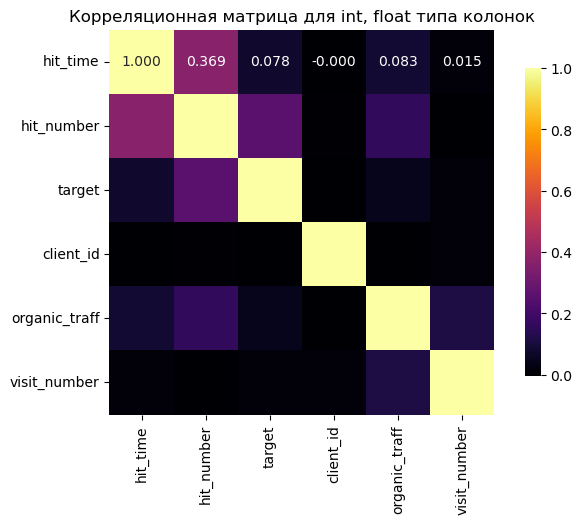

In [36]:
plt.figure(figsize=(8, 5))
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='inferno', square=True, cbar_kws={'shrink': .8})
plt.title('Корреляционная матрица для int, float типа колонок')
plt.show()

In [4]:
df_mean = df[['hit_date', 'target', 'organic_traff']].groupby('hit_date').mean().reset_index()
df_size = df[['hit_date']].groupby('hit_date').size().reset_index(name='active_actions')

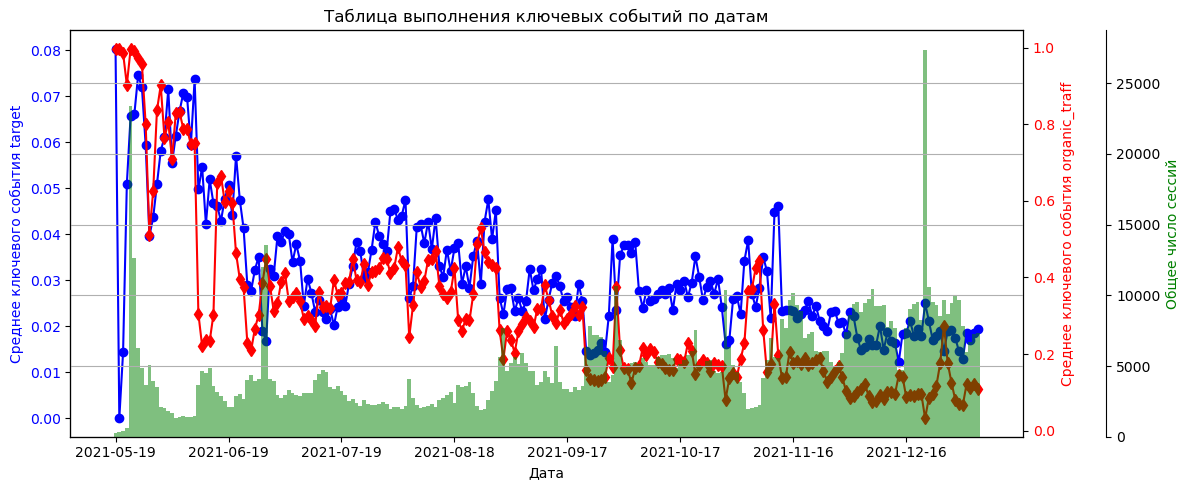

In [5]:
#
# Учитываем что в граффике будут отображаться сессти с приоритетом на target=1 и organic_traff=1
# т.е. ранее те же сессии с target=0 или organic_traff=0 были перезаписаны 
# как только target=0 или organic_traff=0 сессии оказался равен 1
#
fig, ax1 = plt.subplots(figsize=(12, 5))
ax1.set_xlabel('Дата')
ax1.set_ylabel('Среднее ключевого события target', color='blue')
ax1.plot(df_mean['hit_date'], df_mean['target'], marker='o', label='Column target', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Среднее ключевого события organic_traff', color='red')
ax2.plot(df_mean['hit_date'], df_mean['organic_traff'], marker='d', label='Column organic_traff', color='red')
ax2.tick_params(axis='y', labelcolor='red')

ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))
ax3.set_ylabel('Общее число сессий', color='green')
ax3.bar(df_size['hit_date'], df_size['active_actions'], alpha=0.5, color='green', width=1, label='Active actions')

plt.title('Таблица выполнения ключевых событий по датам')
plt.xticks(df_mean['hit_date'][::30], rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

Общее количество траффика растёт, но мы наблюдаем спад органического траффика, 
что сообщает нам о приросте трафика через платную рекламу.

Т.ж. при более высокой активности коэффицент target падает
что т.ж. может указывать на снижение качества рекламной кампании

In [12]:
df['hit_date'].value_counts()

hit_date
2021-12-21    27370
2021-05-24    23367
2021-06-29    13525
2021-05-25    12628
2021-06-28    11988
              ...  
2021-06-05     1303
2021-05-23      589
2021-05-22      419
2021-05-21      338
2021-05-19      274
Name: count, Length: 230, dtype: int64

Напишем функцию для анализа двух популярных дат

In [70]:
def analytics_date(date):

    all_sessions = df[df['hit_date'] == date].shape[0]
    all_target = df[df['hit_date'] == date]['target'].sum()
    all_organic_traff = df[df['hit_date'] == date]['organic_traff'].sum()
    general_add_cam = df[df['hit_date'] == date]['utm_campaign'].value_counts().head(6)
    
    
    print(f"Кол-во сессий 2021-12-21: {all_sessions}\n"
          f"Кол-во target: {all_target}\n"
          f"Кол-во organic_traff: {all_organic_traff}\n"
    )
    for add, values, _ in zip(general_add_cam.index, general_add_cam.values, range(len(general_add_cam.values))):
        target_add = df[
        (df['hit_date'] == date) 
        & (df['utm_campaign'] == add)
        & (df['target'] == 1)
        ]['target'].sum()
        organic_traff_add = df[
        (df['hit_date'] == date) 
        & (df['utm_campaign'] == add)
        & (df['organic_traff'] == 1)
        ]['organic_traff'].sum()
        org_on_targ = df[
        (df['hit_date'] == date) 
        & (df['utm_campaign'] == add)
        & (df['organic_traff'] == 1)
        & (df['target'] == 1)
        ]['organic_traff'].sum()
        
        procent_target = target_add / all_target
        one_target_on_add = values / target_add
        
        print(f"Реклама {_}: {add} \n"
              f"target-оф от неё: {target_add}\n"
              f"Коэффицент от общего числа target: {round(procent_target, 2)}\n"
              f"Показано рекламы на 1 target: {round(one_target_on_add, 2)}\n"
              f"organic_traff првиедено через эту рекламу: {organic_traff_add}\n"
              f"organic_traff реализовал target: {org_on_targ}\n")

In [71]:
date = '2021-12-21'
analytics_date(date)

Кол-во сессий 2021-12-21: 27370
Кол-во target: 684
Кол-во organic_traff: 885

Реклама 0: sbJRYgVfvcnqKJNDDYIr 
target-оф от неё: 443
Коэффицент от общего числа target: 0.65
Показано рекламы на 1 target: 34.36
organic_traff првиедено через эту рекламу: 4
organic_traff реализовал target: 0

Реклама 1: LEoPHuyFvzoNfnzGgfcd 
target-оф от неё: 101
Коэффицент от общего числа target: 0.15
Показано рекламы на 1 target: 50.23
organic_traff првиедено через эту рекламу: 12
organic_traff реализовал target: 0

Реклама 2: UvuMsOSDBWQGOIbDbXfV 
target-оф от неё: 84
Коэффицент от общего числа target: 0.12
Показано рекламы на 1 target: 48.14
organic_traff првиедено через эту рекламу: 3
organic_traff реализовал target: 1

Реклама 3: FTjNLDyTrXaWYgZymFkV 
target-оф от неё: 10
Коэффицент от общего числа target: 0.01
Показано рекламы на 1 target: 81.1
organic_traff првиедено через эту рекламу: 1
organic_traff реализовал target: 0

Реклама 4: zxoiLxhuSIFrCeTLQVWZ 
target-оф от неё: 17
Коэффицент от общего ч

Реализация рекланой кампании на 2021-12-21

Реклама 5: LTuZkdKfxRGVceoWkVyg  реализовывает бесплатный трафик

Реклама 0: sbJRYgVfvcnqKJNDDYIr  явялется более кликабельной и т.ж. является более целевой

Реклама 3: FTjNLDyTrXaWYgZymFkV  самая затратная и менее кликабельна 

In [65]:
date = '2021-05-24'
analytics_date(date)

Кол-во сессий 2021-12-21: 23367
Кол-во target: 1534
Кол-во organic_traff: 23287

Реклама 0: LTuZkdKfxRGVceoWkVyg 
target-оф от неё: 1528
Процент от общего числа target: 99.6%
Показано рекламы на 1 target: 1523.8
organic_traff првиедено через эту рекламу: 23282
organic_traff реализовал target: 1528

Реклама 1: LEoPHuyFvzoNfnzGgfcd 
target-оф от неё: 2
Процент от общего числа target: 0.1%
Показано рекламы на 1 target: 2000.0
organic_traff првиедено через эту рекламу: 0
organic_traff реализовал target: 0

Реклама 2: jfLxUKobDdJlutbwyjaU 
target-оф от неё: 3
Процент от общего числа target: 0.2%
Показано рекламы на 1 target: 633.3
organic_traff првиедено через эту рекламу: 0
organic_traff реализовал target: 0



C:\Users\maks\AppData\Local\Temp\ipykernel_2120\2576565822.py:32: RuntimeWarning: divide by zero encountered in scalar divide
  one_target_on_add = values / target_add


Реклама 3: quxdQHtdlpFZfBZSiXFZ 
target-оф от неё: 0
Процент от общего числа target: 0.0%
Показано рекламы на 1 target: inf
organic_traff првиедено через эту рекламу: 0
organic_traff реализовал target: 0

Реклама 4: yfjcpPqMeNcSIiswGTeQ 
target-оф от неё: 0
Процент от общего числа target: 0.0%
Показано рекламы на 1 target: inf
organic_traff првиедено через эту рекламу: 2
organic_traff реализовал target: 0

Реклама 5: qTERPbkOaRvjtQXXEwdb 
target-оф от неё: 0
Процент от общего числа target: 0.0%
Показано рекламы на 1 target: inf
organic_traff првиедено через эту рекламу: 2
organic_traff реализовал target: 0



Реализация рекланой кампании на 2021-05-24

Реклама 0: LTuZkdKfxRGVceoWkVyg реализовала 99% траффика на эту дату

Теперь я хочу посторить граффики за все даты и доработаю имеющююся функцию записывая данные в df

In [216]:
def analytics_date(df, date):
    df_temp = pd.DataFrame(columns=['date', 'add_compain', 'value_target', 'coff_target', 'add_on_target', 'organic_traff_add', 'organic_traff_on_target_one'])
    all_sessions = df[df['hit_date'] == date].shape[0]
    all_target = df[df['hit_date'] == date]['target'].sum()
    all_organic_traff = df[df['hit_date'] == date]['organic_traff'].sum()
    general_add_cam = df[df['hit_date'] == date]['utm_campaign'].value_counts().head(6)
    
    for add, values, _ in zip(general_add_cam.index, general_add_cam.values, range(len(general_add_cam.values))):
        target_add = df[
        (df['hit_date'] == date) 
        & (df['utm_campaign'] == add)
        & (df['target'] == 1)
        ]['target'].sum()
        organic_traff_add = df[
        (df['hit_date'] == date) 
        & (df['utm_campaign'] == add)
        & (df['organic_traff'] == 1)
        ]['organic_traff'].sum()
        org_on_targ = df[
        (df['hit_date'] == date) 
        & (df['utm_campaign'] == add)
        & (df['organic_traff'] == 1)
        & (df['target'] == 1)
        ]['organic_traff'].sum()

        if (all_target == 0) | (target_add == 0):
            procent_target = 0
        else:
            procent_target = target_add / all_target
        
        if (values == 0) | (target_add == 0):
            one_target_on_add = 0
        else:
            one_target_on_add = values / target_add
        
        new_row = [date, add, target_add, round(procent_target, 2), round(one_target_on_add, 2), organic_traff_add, org_on_targ]
        df_temp.loc[len(df_temp)] = new_row
    return df_temp

In [217]:
df_analytics = pd.DataFrame()
dates = df['hit_date'].unique()
df_analytics = pd.DataFrame(columns=[
    'date', 
    'add_compain', 
    'value_target', 
    'coff_target', 
    'add_on_target', 
    'organic_traff_add', 
    'organic_traff_on_target_one'
])

for date in dates:
    df_temp = analytics_date(df, date)
    df_analytics = pd.concat([df_analytics, df_temp], ignore_index=True)

C:\Users\maks\AppData\Local\Temp\ipykernel_2120\3430099788.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_analytics = pd.concat([df_analytics, df_temp], ignore_index=True)


In [168]:
df_analytics['date'] = pd.to_datetime(df_analytics['date'])
df_analytics

,date,add_compain,value_target,coff_target,add_on_target,organic_traff_add,organic_traff_on_target_one
0,2021-11-10,LEoPHuyFvzoNfnzGgfcd,94,0.62,45.43,9,2
1,2021-11-10,LTuZkdKfxRGVceoWkVyg,30,0.20,32.60,907,28
2,2021-11-10,FTjNLDyTrXaWYgZymFkV,2,0.01,389.50,0,0
3,2021-11-10,okTXSMadDkjvntEHzIjp,0,0.00,0.00,288,0
4,2021-11-10,ascPqxFuFewWWZSVMpkh,22,0.14,9.73,1,1
...,...,...,...,...,...,...,...
1364,2022-01-02,MDkExPKZNAIpCZgwwLjJ,0,0.00,0.00,0,0
1365,2022-01-02,yhWEanrxDSAcPHHkrasG,1,0.01,121.00,84,1
1366,2022-01-02,UdWbkgypzlAKtkKKMZsE,0,0.00,0.00,0,0
1367,2021-05-21,LTuZkdKfxRGVceoWkVyg,0,NaN,0.00,337,0


Построим граффик чтобы узнать действительно ли качаство рекламной кампании падает и привлечение новых клиентов становится дороже

In [213]:
max_values_add_on_date = df_analytics[['date', 'value_target', 'add_on_target', 'add_compain']].loc[df_analytics.groupby('date')['value_target'].idxmax()]
full_target_day = df_analytics.groupby('date')['value_target'].sum().reset_index()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


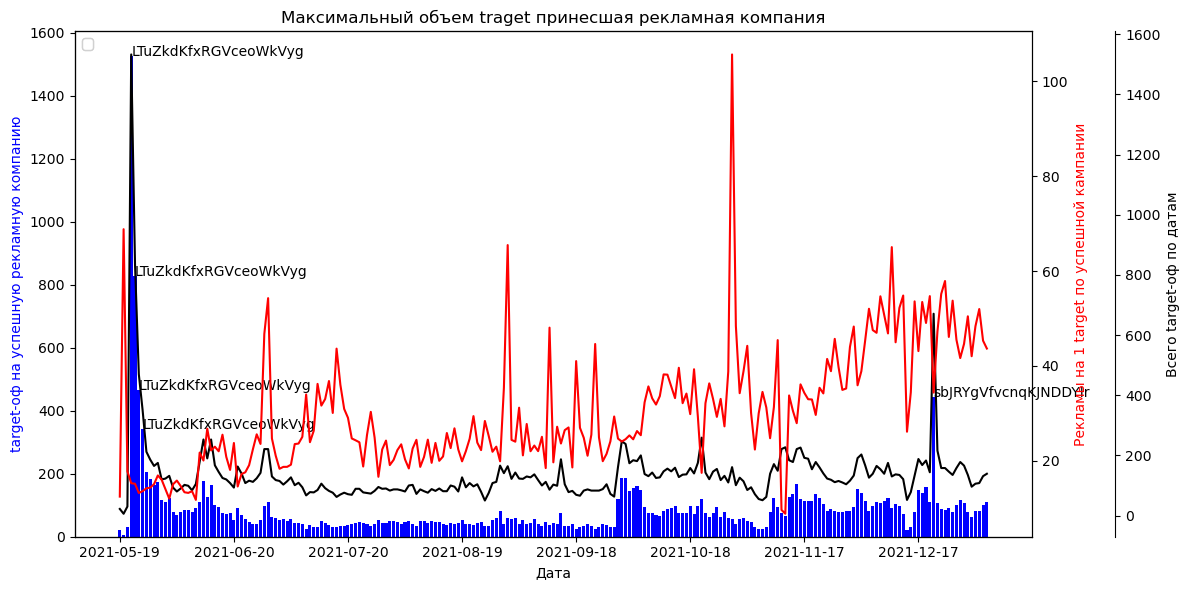

In [215]:
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.set_xlabel('Дата')
ax1.set_ylabel('Значения')
ax1.bar(max_values_add_on_date['date'], max_values_add_on_date['value_target'], color='blue')

for a, row in max_values_add_on_date.iterrows():
    if row['value_target'] > 210:
        ax1.text(row['date'], row['value_target'], row['add_compain'])
              
ax1.set_ylabel('target-оф на успешную рекламную компанию', color='blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Всего target-оф по датам', color='black')
ax2.plot(full_target_day['date'], full_target_day['value_target'], color='black')
ax2.legend(loc='upper left')

ax3 = ax1.twinx()
ax2.spines['right'].set_position(('outward', 60))  
ax3.set_ylabel('Рекламы на 1 target по успешной кампании', color='red')
ax3.plot(max_values_add_on_date['date'], max_values_add_on_date['add_on_target'], color='red')
ax3.legend(loc='upper left')

plt.title('Максимальный объем traget принесшая рекламная компания')
plt.xticks(full_target_day['date'][::30], rotation=40)
plt.tight_layout()
plt.show()

На граффике видно, что действительно для target события объем рекламы на одно действие со временем увеличивается.

Ещё можно заметить что при стабильном граффике компании набирающие большую часть traget трафика не всегда эффективны(компании), что можно видеть по выбросам на красной линии относительно синих столбцов.

При стабильном граффике в большинстве своём успешная рекламная кампания не занимает больше половины target-оф. 

На графике видны выбросы в начале граффика основыной траффик принесла одна рекламная компания. 